In [1]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import loompy
import velocyto as vcy
import logging
from sklearn.neighbors.kde import KernelDensity
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
%matplotlib inline

/data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2018-05-22 18:11:50,109 - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown
2018-05-22 18:11:50,116 - DEBUG - backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
plt.rcParams['pdf.fonttype'] = 42

In [3]:
def ixs_thatsort_a2b(a: np.ndarray, b: np.ndarray, check_content: bool=True) -> np.ndarray:
    "This is super duper magic sauce to make the order of one list to be like another"
    if check_content:
        assert len(np.intersect1d(a, b)) == len(a), f"The two arrays are not matching"
    return np.argsort(a)[np.argsort(np.argsort(b))]

def despline():
    ax1 = plt.gca()
    # Hide the right and top spines
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')

In [4]:
dp = dict(min_expr_counts=30,
          min_cells_express=20,
          N=1500,
          min_expr_counts_U=20,
          min_cells_express_U=15,
          min_avg_U=0.008,
          min_avg_S=0.08,
          n_comps = 20,
          limit_gamma=False,
          fit_offset=False,
          n_neighbors = 40,
          k = 70)

In [ ]:
!mkdir data

In [ ]:
from urllib.request import urlretrieve
urlretrieve("http://pklab.med.harvard.edu/velocyto/Haber_et_al/Haber_et_al.loom",
            "data/Haber_et_al.loom")
urlretrieve("http://pklab.med.harvard.edu/velocyto/Haber_et_al/goatools_cellcycle_genes.txt",
            "data/goatools_cellcycle_genes.txt")

In [5]:
cell_cycle_genes = open("data/goatools_cellcycle_genes.txt").read().split()

In [6]:
# Crate an analysis object
vlm = vcy.VelocytoLoom("data/Haber_et_al.loom")  # CHANGE THIS PATH TO YOUR LOCAL PATH

In [7]:
vlm.filter_cells(~np.in1d(vlm.ca["Bamfile"], ["Atlas1", "Atlas2", "Atlas6", "Atlas5"]))

# Extra filtering

## Remove low detection

Text(0,0.5,'unspliced')

2018-05-22 18:11:56,610 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


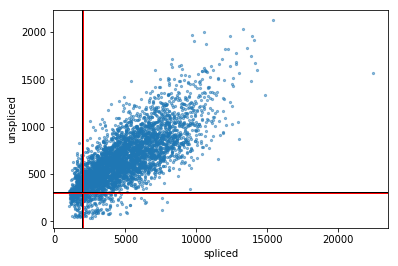

In [8]:
plt.scatter(vlm.initial_cell_size, vlm.initial_Ucell_size, alpha=0.5, s=5)
plt.axvline(2000, c="r", lw=1)
plt.axvline(np.percentile(vlm.initial_cell_size, 8), c="k", lw=1)
plt.axhline(300, c="r", lw=1)
plt.axhline(np.percentile(vlm.initial_Ucell_size, 8), c="k", lw=1)
plt.xlabel("spliced"); plt.ylabel("unspliced")

In [9]:
vlm.filter_cells(bool_array=(vlm.initial_Ucell_size > 300) & (vlm.initial_cell_size > 2000))

## Merge some labels

In [10]:
# Read column attributes form the loom file and specify colors
colors_dict = {'Endocrine':np.array([137, 34, 81]),
 'Enterocyte.Immature.Distal':np.array([130, 162, 209]),
 'Enterocyte.Immature.Proximal':np.array([224, 139, 183]),
 'Enterocyte.Mature.Distal':np.array([52, 127, 184]),
 'Enterocyte.Mature.Proximal':np.array([150, 81, 156]),
 'Enterocyte.Progenitor':np.array([224, 139, 104]),
 'Enterocyte.Progenitor.Early':np.array([96, 97, 96]),
 'Enterocyte.Progenitor.Late':np.array([107, 194, 165]),
 'Goblet':np.array([225,34,46]),
 'Paneth':np.array([190,190,190]),
 'Stem':np.array([37,139,72]),
 'TA.Early':np.array([249,214,64]),
 'TA.G1':np.array([164,87,44]),
 'TA.G2':np.array([164,209,235]),
 'Tuft':np.array([223,127,49]),
 'TA':np.array([164,87,44]),}
colors_dict = {k:v/256 for k, v in colors_dict.items()}
vlm.ca["Celltype"][np.in1d(vlm.ca["Celltype"], ["TA.G1", "TA.G2"])] = "TA"
vlm.set_clusters(vlm.ca["Celltype"], cluster_colors_dict=colors_dict)

(0.8, 2.0, -1.0, 8.0)

2018-05-22 18:15:24,217 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0 to DejaVu Sans ('/data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


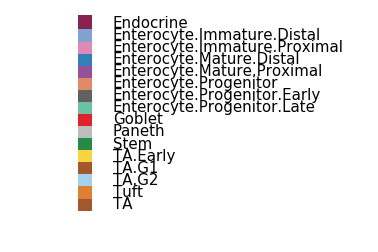

In [23]:
for zz, (k, v) in enumerate(list(colors_dict.items())[::-1]):
    plt.scatter(1, zz/2., c=v, marker="s", lw=0., edgecolor="k", s=220)
    plt.text(1.1, zz/2., k, fontdict={"va":"center", "size":15})
plt.xlim(0.8,2)
plt.ylim(-1,8)
plt.axis("off")

In [36]:
cellamount_dict = {'Enterocyte.Immature.Distal': 244,
 'Enterocyte.Immature.Proximal': 144,
 'Enterocyte.Mature.Distal': 148,
 'Enterocyte.Mature.Proximal': 364,
 'Enterocyte.Progenitor': 117,
 'Enterocyte.Progenitor.Early': 489,
 'Enterocyte.Progenitor.Late': 179,
 'Goblet': 269,
 'Paneth': 78,
 'Stem': 666,
 'TA': 458,
 'TA.Early': 270,
 'Tuft': 76,
 'Endocrine': 137}

In [40]:
dict(zip(*np.unique(vlm.ca["Celltype"], return_counts=1))) ==cellamount_dict

True

# Downsample cells

In [27]:
from scipy.stats.mstats import gmean, hmean

In [51]:
tosample = int(np.ceil(np.mean(np.unique(vlm.ca["Celltype"], return_counts=1)[1])))
np.random.seed(19900715)
downsaple_ixs = []
for ct in np.unique(vlm.ca["Celltype"]):
    ixs = np.where(vlm.ca["Celltype"] == ct)[0]
    downsaple_ixs.append(np.random.choice(ixs, min(tosample, len(ixs)), replace=False))
downsaple_ixs = np.concatenate(downsaple_ixs)
len(downsaple_ixs)

2683

In [52]:
vlm.filter_cells(bool_array=np.in1d(np.arange(vlm.S.shape[1]), downsaple_ixs))

# Diagnostics

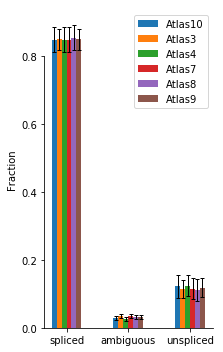

In [53]:
vlm.plot_fractions()

In [54]:
vlm.filter_genes(by_custom_array=~np.in1d(vlm.ra["Gene"], cell_cycle_genes))

2018-05-22 18:30:27,393 - DEBUG - Filtering by custom boolean array


In [55]:
vlm.score_detection_levels(min_expr_counts=dp["min_expr_counts"], min_cells_express=dp["min_cells_express"])
vlm.filter_genes(by_detection_levels=True)

2018-05-22 18:31:00,525 - DEBUG - Filtering by detection level


In [56]:
# Feature selection - enrichment score
vlm._normalize_S(relative_size=vlm.S.sum(0),
                 target_size=np.median(vlm.S.sum(0)))

M = np.zeros((vlm.S.shape[0], len(np.unique(vlm.cluster_ix))))
F = np.zeros((vlm.S.shape[0], len(np.unique(vlm.cluster_ix))))
for i in np.unique(vlm.cluster_ix):
    D = vlm.S_sz[:, vlm.cluster_ix ==i]
    M[:, i] = D.mean(1)
    F[:, i] = (D>0).mean(1)
Enrich = (M / vlm.S_sz.mean(1)[:,None]) * (F / (vlm.S_sz > 0).mean(1)[:,None])

In [57]:
n = 110
selected = []
for i in np.unique(vlm.cluster_ix):
    selected.append(np.argsort(Enrich[:,i])[::-1][:n])
selected = np.unique(np.concatenate(selected))
selected.shape

(1296,)

In [58]:
vlm.filter_genes(by_custom_array=np.in1d(np.arange(vlm.S.shape[0]), selected))

2018-05-22 18:31:22,527 - DEBUG - Filtering by custom boolean array


In [59]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=dp["min_expr_counts_U"], min_cells_express_U=dp["min_cells_express_U"])
vlm.score_cluster_expression(min_avg_U=dp["min_avg_U"], min_avg_S=dp["min_avg_S"])
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)

2018-05-22 18:31:27,648 - INFO - Cluster: Endocrine (137 cells)
2018-05-22 18:31:27,653 - INFO - Cluster: Enterocyte.Immature.Distal (244 cells)
2018-05-22 18:31:27,661 - INFO - Cluster: Enterocyte.Immature.Proximal (144 cells)
2018-05-22 18:31:27,666 - INFO - Cluster: Enterocyte.Mature.Distal (148 cells)
2018-05-22 18:31:27,671 - INFO - Cluster: Enterocyte.Mature.Proximal (260 cells)
2018-05-22 18:31:27,679 - INFO - Cluster: Enterocyte.Progenitor (117 cells)
2018-05-22 18:31:27,683 - INFO - Cluster: Enterocyte.Progenitor.Early (260 cells)
2018-05-22 18:31:27,690 - INFO - Cluster: Enterocyte.Progenitor.Late (179 cells)
2018-05-22 18:31:27,696 - INFO - Cluster: Goblet (260 cells)
2018-05-22 18:31:27,704 - INFO - Cluster: Paneth (78 cells)
2018-05-22 18:31:27,707 - INFO - Cluster: Stem (260 cells)
2018-05-22 18:31:27,714 - INFO - Cluster: TA (260 cells)
2018-05-22 18:31:27,722 - INFO - Cluster: TA.Early (260 cells)
2018-05-22 18:31:27,730 - INFO - Cluster: Tuft (76 cells)
2018-05-22 18:3

In [60]:
combined_size = (vlm.S.sum(0) / np.percentile(vlm.S.sum(0), 95)) + (vlm.initial_cell_size / np.percentile(vlm.initial_cell_size, 95))
combined_Usize = (vlm.U.sum(0) / np.percentile(vlm.U.sum(0), 95)) + (vlm.initial_Ucell_size / np.percentile(vlm.initial_Ucell_size, 95))
vlm._normalize_S(relative_size=0.25*combined_size*np.median(vlm.S.sum(0)),
                 target_size=np.median(vlm.S.sum(0)))
vlm._normalize_U(relative_size=0.5*combined_Usize*np.median(vlm.U.sum(0)),
                 target_size=np.median(vlm.U.sum(0)))

18

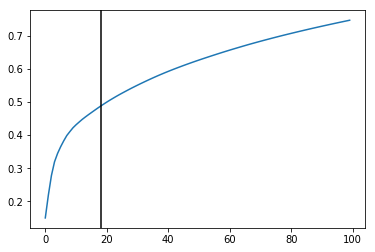

In [61]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.006))[0][0]
plt.axvline(n_comps, c="k"); n_comps

Text(0,0.5,'PC5')

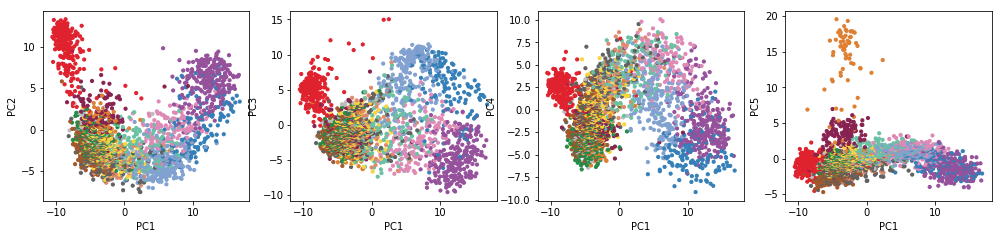

In [62]:
plt.figure(None, (17,3.5))
plt.subplot(141)
vcy.scatter_viz(vlm.pcs[:,0], vlm.pcs[:,1], c=vlm.colorandum,s=10)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.subplot(142)
vcy.scatter_viz(vlm.pcs[:,0], vlm.pcs[:,2], c=vlm.colorandum,s=10)
plt.xlabel("PC1"); plt.ylabel("PC3")
plt.subplot(143)
vcy.scatter_viz(vlm.pcs[:,0], vlm.pcs[:,3], c=vlm.colorandum,s=10)
plt.xlabel("PC1"); plt.ylabel("PC4")
plt.subplot(144)
vcy.scatter_viz(vlm.pcs[:,0], vlm.pcs[:,4], c=vlm.colorandum,s=10)
plt.xlabel("PC1"); plt.ylabel("PC5")

In [63]:
import cytograph

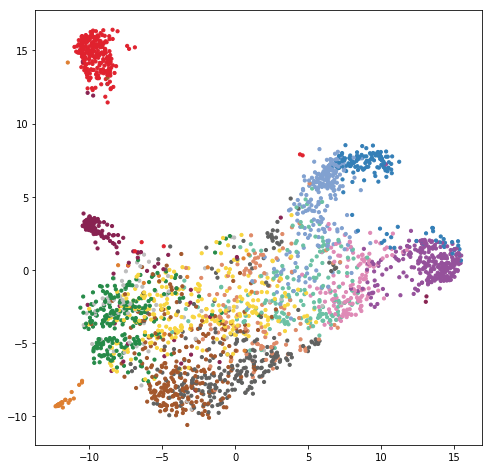

In [64]:
ts = cytograph.TSNE(perplexity=230).layout(vlm.pcs[:,:9])
plt.figure(None,(8,8))
vcy.scatter_viz(ts[:,0], ts[:,1], c=vlm.colorandum, s=10)

In [68]:
k = dp["k"] = 70
vlm.knn_imputation(n_pca_dims=9, k=k, balanced=True, b_sight=k*6, b_maxl=int(k*3.5), n_jobs=16)
vlm.fit_gammas(limit_gamma=False, fit_offset=True)

2018-05-22 18:33:43,380 - DEBUG - First search the 420 nearest neighbours for 2683
2018-05-22 18:33:44,019 - DEBUG - Using the initialization network to find a 70-NN graph with maximum connectivity of 245
2018-05-22 18:33:44,039 - DEBUG - Returning sparse matrix


In [69]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift(assumption="constant_unspliced", delta_t=4)
vlm.extrapolate_cell_at_t(delta_t=1.)

In [70]:
vlm.ts = ts

In [71]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="ts", transform="sqrt", psc=1,
                             n_neighbors=30, knn_random=True, sampled_fraction=0.95,
                             calculate_randomized=True)

2018-05-22 18:34:17,027 - DEBUG - Calculate KNN in the embedding space
2018-05-22 18:34:17,739 - DEBUG - Correlation Calculation 'knn_random'
2018-05-22 18:34:17,810 - DEBUG - Correlation Calculation for negative control
2018-05-22 18:34:17,884 - WARNING - Nans encountered in corrcoef and corrected to 1s. If not identical cells were present it is probably a small isolated cluster converging after imputation.
2018-05-22 18:34:17,899 - WARNING - Nans encountered in corrcoef_random and corrected to 1s. If not identical cells were present it is probably a small isolated cluster converging after imputation.
2018-05-22 18:34:17,900 - DEBUG - Done Correlation Calculation


In [73]:
vlm.calculate_embedding_shift(sigma_corr = 0.05)

2018-05-22 18:34:33,454 - DEBUG - Calculate transition probability
2018-05-22 18:34:33,510 - DEBUG - Calculate transition probability for negative control


In [ ]:
vlm.calculate_grid_arrows(smooth=0.85, steps=(32, 32), n_neighbors=50)

(0.8, 2.0, -1.0, 8.0)

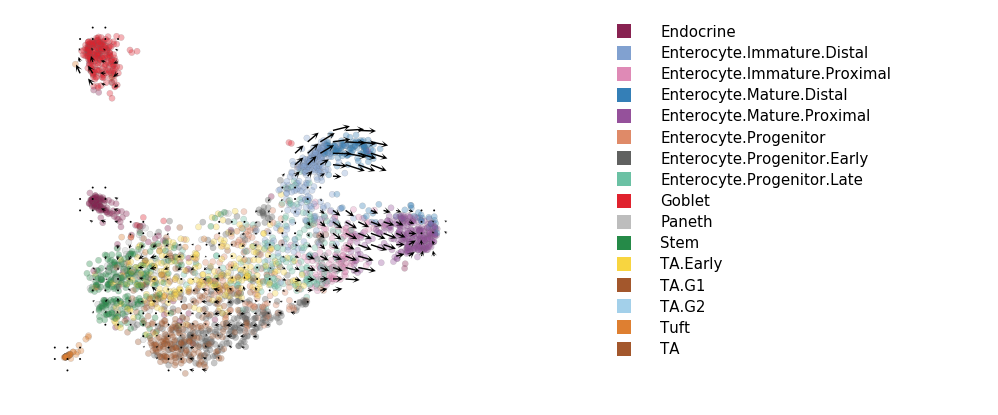

In [75]:
plt.figure(None,(17,7))
plt.subplot(121)
vlm.plot_grid_arrows(quiver_scale=1.4,
                     scatter_kwargs_dict={"alpha":0.35, "lw":0.35, "edgecolor":"0.4", "s":38, "rasterized":True},
                     min_mass=5.5, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, minlength=1.5,
                     plot_random=False, scale_type="relative")
plt.subplot(122)
for zz, (k, v) in enumerate(list(colors_dict.items())[::-1]):
    plt.scatter(1, zz/2., c=v, marker="s", lw=0., edgecolor="k", s=220)
    plt.text(1.1, zz/2., k, fontdict={"va":"center", "size":15})
plt.xlim(0.8,2)
plt.ylim(-1,8)
plt.axis("off")
#plt.savefig("../figures/Haber_vellocity_field.pdf")

# Try to plot cell cycle genes that were excluded from the analysis

In [76]:
ds = loompy.connect("data/Haber_et_al.loomds ")

S = np.array(ds["spliced"][:])
cellids = np.array(ds.ca.CellID)
genenames = np.array(ds.ra.Gene)

In [77]:
ds.close()

In [78]:
mask = np.in1d(cellids, vlm.ca["CellID"])
cellids = cellids[mask]
S = S[:, mask]

mask = (S.sum(1) > 20) & ((S>0).sum(1) > 15)
genenames = genenames[mask]
S = S[mask, :]

np.alltrue(cellids == vlm.ca["CellID"])

# Size normalize
S_sz = S / S.sum(0)
# Impute
Sx_sz = vcy.convolve_by_sparse_weights(S_sz, vlm.knn_smoothing_w)

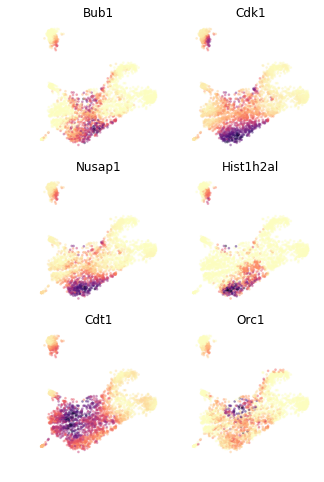

In [79]:
plt.figure(None, (5,8))
gs = plt.GridSpec(3,2)
gene_list = ['Bub1', 'Cdk1', 
             'Nusap1', 'Hist1h2al',
              "Cdt1", "Orc1",]
for i, gene in enumerate(gene_list):
    plt.subplot(gs[i])
    colorandum = Sx_sz[np.where(genenames == gene)[0][0], :]
    vcy.scatter_viz(vlm.ts[:,0], vlm.ts[:, 1], c=colorandum, cmap="magma_r", alpha=0.35, s=3, rasterized=True)
    plt.title(gene)
    plt.axis("off")
#plt.savefig("../figures/Haber_cellcycle_genes.pdf")

In [84]:
k = dp["k"] = 150
vlm.knn_imputation(n_pca_dims=9, k=k, balanced=True, b_sight=k*6, b_maxl=int(k*3.5), n_jobs=16)

2018-05-22 18:41:59,714 - DEBUG - First search the 900 nearest neighbours for 2683
2018-05-22 18:42:00,449 - DEBUG - Using the initialization network to find a 150-NN graph with maximum connectivity of 525
2018-05-22 18:42:00,480 - DEBUG - Returning sparse matrix


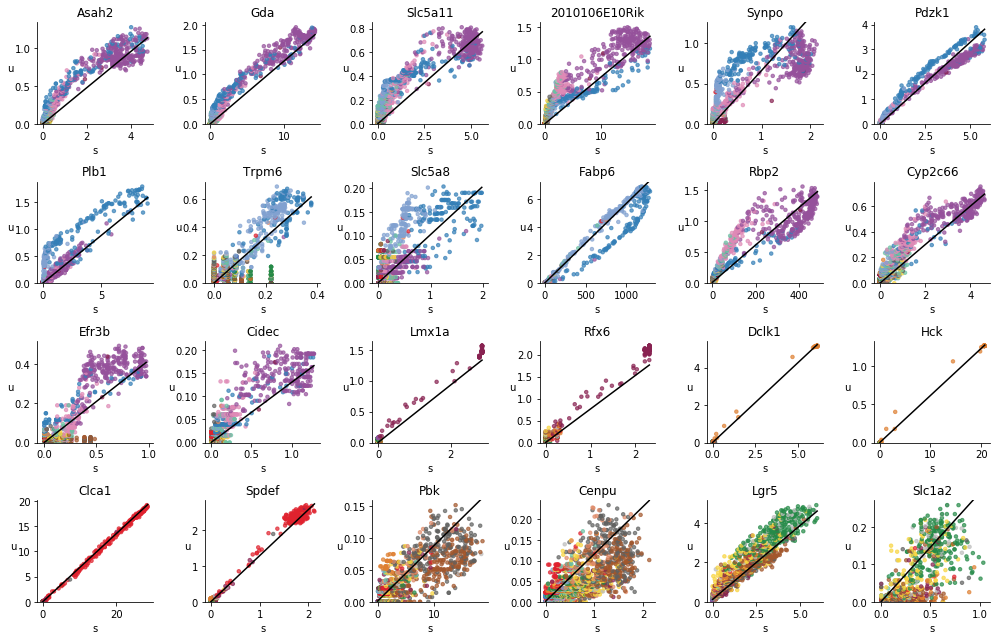

In [85]:
genes = ["Asah2", "Gda", "Slc5a11", '2010106E10Rik',  "Synpo", 'Pdzk1',
         "Plb1", 'Trpm6',  "Slc5a8", 'Fabp6',   'Rbp2', "Cyp2c66", 'Efr3b', 'Cidec', 
         'Lmx1a', "Rfx6",  'Dclk1', 'Hck',  'Clca1',  "Spdef",  
         'Pbk', "Cenpu", "Lgr5", "Slc1a2"]

plt.figure(None, (14,9))
gs = plt.GridSpec(4,6)
for i, gn in enumerate(genes):
    plt.subplot(gs[i])
    try:
        ix=np.where(vlm.ra["Gene"] == gn)[0][0]
    except:
        continue
    vcy.scatter_viz(vlm.Sx_sz[ix,:], vlm.Ux_sz[ix,:], c=vlm.colorandum, s=12, alpha=0.7, rasterized=True)
    plt.title(gn)
    xnew = np.linspace(0,vlm.Sx[ix,:].max())
    plt.plot(xnew, vlm.gammas[ix] * xnew + vlm.q[ix], c="k")
    plt.ylim(0, np.max(vlm.Ux_sz[ix,:])*1.05)
    plt.xlabel("s")
    plt.ylabel("u", rotation=0)
    despline()
plt.tight_layout()
